# Optimizing Job Offers

In a highly competitive job market, recruiters face the challenge of designing salary packages taht attract top talent while staying within budget constrains. Without a data-driven approach, this process becomes inefficient and subjective, leading to missed opportunities and inflated costs.

By leveraging data science and optimization techniques, organizations can align their salary packages with market trends and skill demands. This not only ensures cost efficiency but also enhances the ability to attract and retain high0performing candidates.

We're going to use https://www.kaggle.com/datasets/saurabhbadole/latest-data-science-job-salaries-2024/data as our dataset. 

### Goals

* Primary goal: to design optimal salary packages based on market trends and required skill sets.

* Secondary goal: to minimize hiring costs without compromising quality and provide actionable insights for recruiters to make informed decisions.

### Approach

A combination of Machine learning and linear programming is used.

* Predict salaries for various roles based on historical data adn market trends.(Done by my teammate)

* Use linear programming to minimize costs while meeting hiring constraints like skill requirements and budget caps.

### Expected Outcomes

* Data-Driven Insights: recuriters will receive optimized salary recommendations that align with market benchmarks.

* Cost Efficiency: minimized hiring expenses by offering competitive yet cost-effctive packages.

* Talent Retention: increased satisfaction and retention by providing fair and attractive salaries.

### Why optimizing job offers metter

* For Recruiters: gain a competitive edge in hiring top talent by leveraging a data-driven, systematic approach.

* For Organizations: drive long-term success by aligning financial goals with talent acquisition strategies.

* For Candidates: ensure fair compensation that reflects their skillls and market value.

In [53]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import ticker
from xgboost import XGBRegressor
from IPython.display import Image
from itertools import combinations
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [54]:
df = pd.read_csv('DataScience_salaries_2024.csv')
df.head()

work_year experience_level employment_type                       job_title  \
0       2021               MI              FT                  Data Scientist   
1       2021               MI              FT                 BI Data Analyst   
2       2020               MI              FT                  Data Scientist   
3       2021               MI              FT                     ML Engineer   
4       2022               SE              FT  Lead Machine Learning Engineer   

     salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  30400000             CLP          40038                 CL           100   
1  11000000             HUF          36259                 HU            50   
2  11000000             HUF          35735                 HU            50   
3   8500000             JPY          77364                 JP            50   
4   7500000             INR          95386                 IN            50   

  company_location company_size  
0               CL            L  
1               US            L  
2               HU            L  
3               JP            S  
4               IN            L

Features:
1. work_year: The year of the data related to the job salary.
2. experience_level: The level of experience of the employee (e.g., entry-level, mid-level, senior-level).
3. employment_type: The type of employment (e.g., full-time, part-time, contract).
4. job_title: The title or role of the employee within the data science field.
5. salary: The salary of the employee.
6. salary_currency: The currency in which the salary is denoted.
7. salary_in_usd: The salary converted to US dollars for standardization.
8. employee_residence: The residence location of the employee.
9. remote_ratio: The ratio of remote work allowed for the position.
10. company_location: The location of the company.
11. company_size: The size of the company based on employee count or revenue.

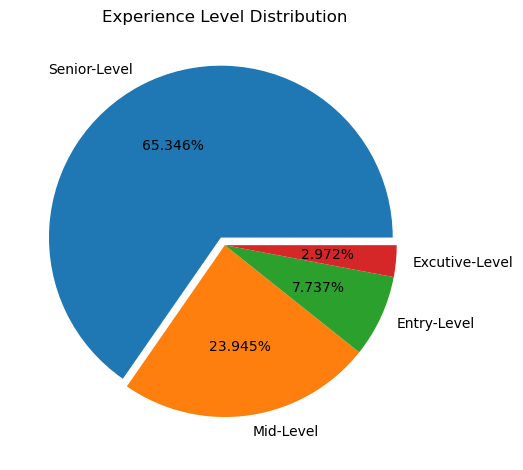

In [55]:
# replace 'experience_level' codes with full descriptions for better understanding
df['experience_level'] = df['experience_level'].replace({'EN':'Entry-Level','MI': 'Mid-Level', 'SE': 'Senior-Level', 'EX': 'Excutive-Level'})

# calculate the normalized(percentage) value counts of experience levels
ex_level = df['experience_level'].value_counts(normalize = True)

#exploding the engry-level slice to make it more prominent
explode = (0.05, 0, 0, 0)

plt.pie(
    ex_level.values,
    labels = ex_level.index, 
    autopct = '%1.3f%%',
    explode = explode
)

plt.title('Experience Level Distribution')
plt.tight_layout()
plt.show()

We can notice that Seinior-Level accounts for 65.346%, Mid-Level accounts for 23.945%, Entry-Level accounts for 7.737%, Excutive-Level accounts for 2.972%

In [56]:
job_titles = df['job_title'].value_counts()
job_titles

Data Engineer                      3162
Data Scientist                     3015
Data Analyst                       2189
Machine Learning Engineer          1542
Research Scientist                  475
                                   ... 
Deep Learning Researcher              1
Big Data Developer                    1
AWS Data Architect                    1
Staff Machine Learning Engineer       1
CRM Data Analyst                      1
Name: job_title, Length: 153, dtype: int64

To improve the clarity and effectiveness of the chart, we only focus on top 10 of the job titles.

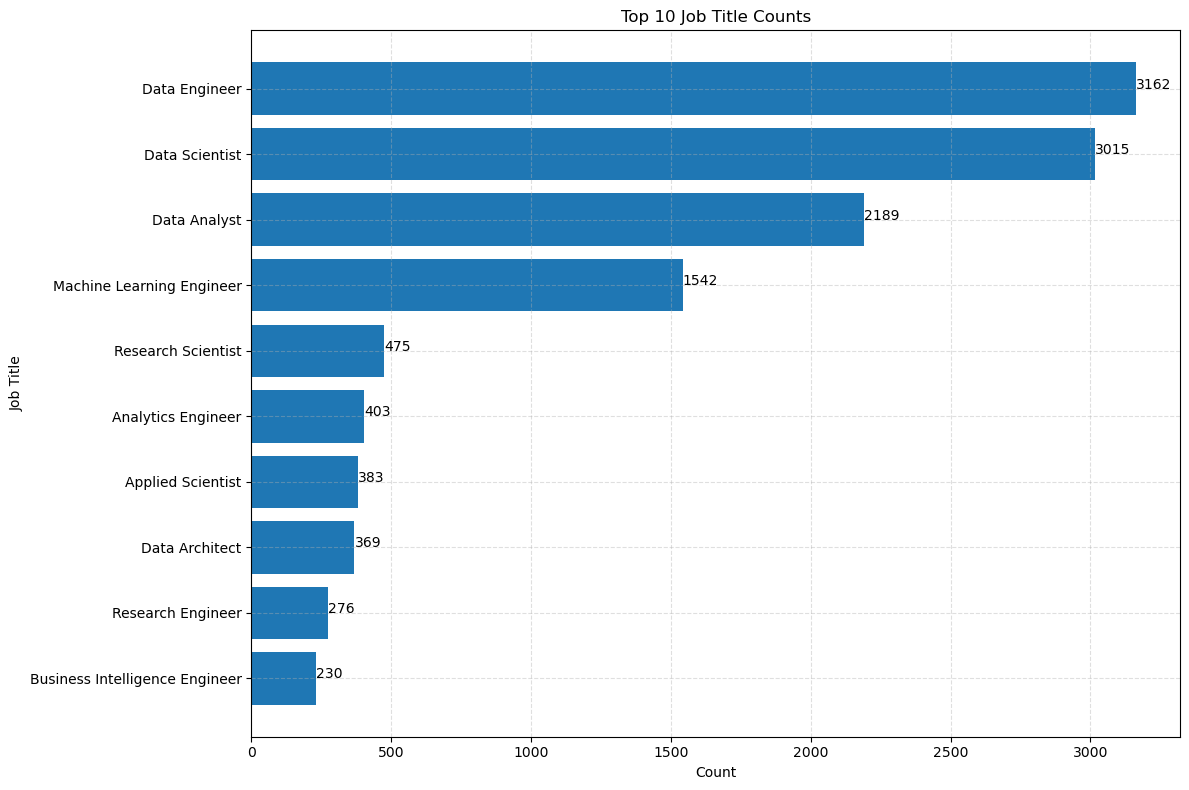

In [57]:
# Get the top 10 job titles and their counts, sorted by count in ascending order
top10 = df['job_title'].value_counts()[:10].sort_values(ascending = True)

fig, ax = plt.subplots(figsize = (12, 8))

bars = ax.barh(top10.index, top10.values)
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.0f}')

ax.set_title('Top 10 Job Title Counts')
ax.set_xlabel('Count')
ax.set_ylabel('Job Title')
ax.grid(linestyle='--', alpha = .4)
plt.tight_layout()
plt.show()

We can see Data Scientist, Data Engineer and Data Analyst ranked top 3 frequent job titles over 2020 - 2024, but we can also notice that the other 7 job titles are related.

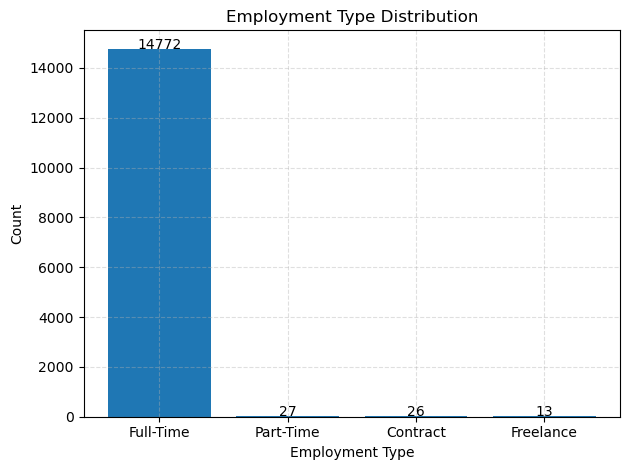

In [58]:
df['employment_type'] = df['employment_type'].replace({'FT': 'Full-Time', 'PT': 'Part-Time', 'CT': 'Contract', 'FL': 'Freelance'})

employment_type = df['employment_type'].value_counts()

bars = plt.bar(employment_type.index, employment_type.values)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.0f}', ha = 'center')

plt.title('Employment Type Distribution')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.grid(linestyle='--', alpha = .4)
plt.tight_layout()
plt.show()

We see that most of employee type is Full-Time.

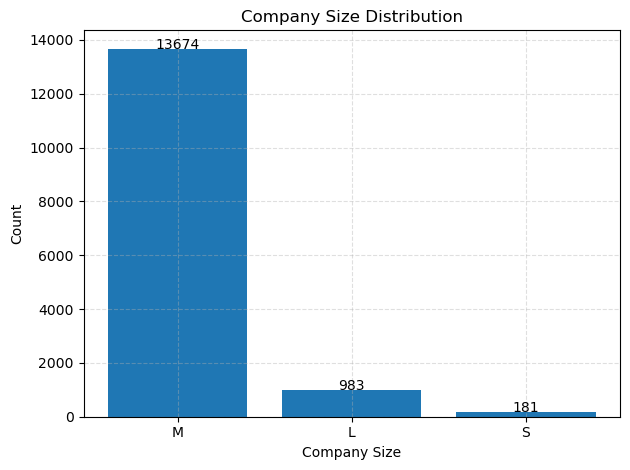

In [59]:
company_size = df['company_size'].value_counts()

bars = plt.bar(company_size.index, company_size.values)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.0f}', ha = 'center')

plt.title('Company Size Distribution')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.grid(linestyle='--', alpha = .4)
plt.tight_layout()
plt.show()

We can see medium company size has the most count, then the large, small company has less count.

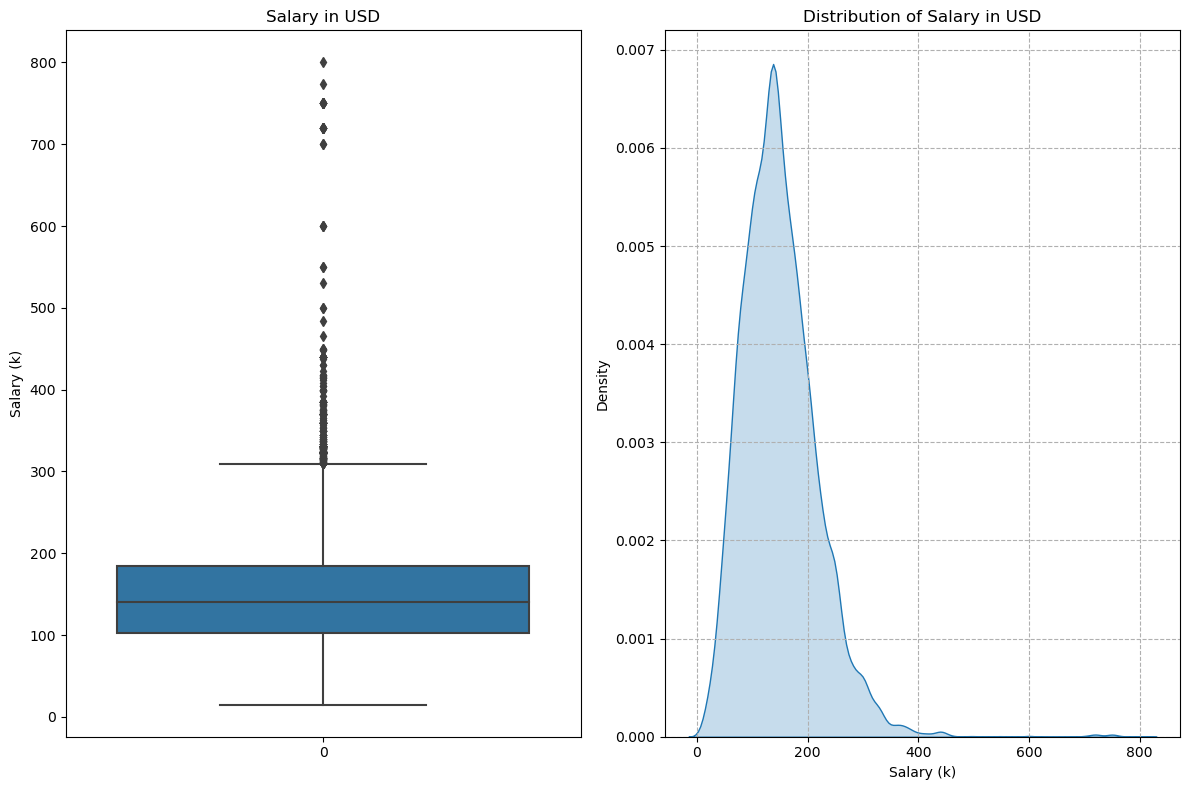

Mean of salary: 149,874.72 USD
Q1: 102,000.00 USD
Q3: 185,900.00 USD
Standard Deviation: 69,009.18 USD
Minimum: 15,000.00 USD
Maximum: 800,000.00 USD


In [60]:
salary = df['salary_in_usd']

# Convert to k
salary_k = salary // 1000  

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Boxplot
sns.boxplot(salary_k, ax=axes[0])
axes[0].set_title('Salary in USD')
axes[0].set_xlabel('')
axes[0].set_ylabel('Salary (k)')


# KDE plot 
sns.kdeplot(salary_k, ax=axes[1], fill=True)
axes[1].set_title('Distribution of Salary in USD')
axes[1].set_xlabel('Salary (k)')
axes[1].set_ylabel('Density')

plt.grid(True, linestyle = '--')
plt.tight_layout()
plt.show()

#  statistical values
print(f"Mean of salary: {salary.mean():,.2f} USD\n"
      f"Q1: {salary.quantile(0.25):,.2f} USD\n"
      f"Q3: {salary.quantile(0.75):,.2f} USD\n"
      f"Standard Deviation: {salary.std():,.2f} USD\n"
      f"Minimum: {salary.min():,.2f} USD\n"
      f"Maximum: {salary.max():,.2f} USD")


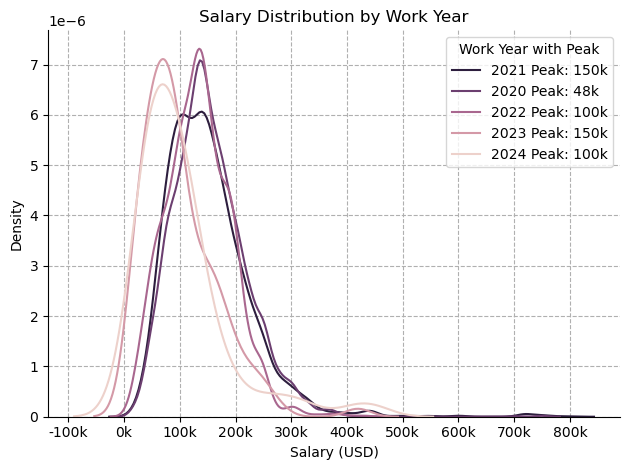

In [61]:
# create kde plot for salary vs work_year
ax = sns.kdeplot(data=df, x='salary_in_usd', hue='work_year', common_norm=False)

legend_labels = []
for year in df['work_year'].unique():
    subset = df[df['work_year'] == year]
    peak = subset['salary_in_usd'].mode()[0]
    legend_labels.append(f'{year} Peak: {peak / 1000:.0f}k')

ax.legend(title="Work Year with Peak", labels=legend_labels)

# Format axes and title
ax.set(xlabel='Salary (USD)', ylabel='Density', title='Salary Distribution by Work Year')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x / 1000:.0f}k'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))

# Adjust aesthetics
ax.spines[['top', 'right']].set_visible(False)
plt.grid(linestyle = '--')
plt.tight_layout()
plt.show()


The distribution are skewed right in year 2020-2021, with peaks concentrated around \\$50-75K, reflecting a relatively narrow salary range.

For the years 2022-2023, the distribution has slightly shifted to the right, with peaks around \\$130-140K. 

In other words, the 2022-2023 data shows broader salary ranges and a notable extension into higher levels, exceeding \\$300K.

And for this year, 2024, the distribution has 2 peak which is bimodal, featuring peaks around \\$100K and \\$150K. That indicates potential salary stratification or the emergency of 2 distinct compensation tiers.

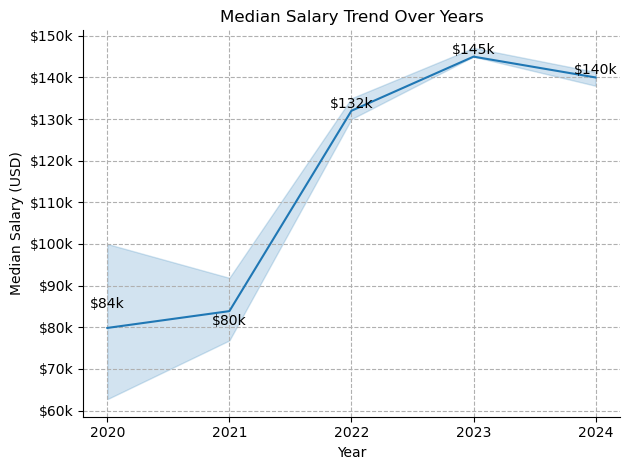

In [62]:
fig, ax = plt.subplots()

# Plot the median salary trend with 95% confidence interval (CI)
sns.lineplot(data=df, x='work_year', y='salary_in_usd', estimator='median', errorbar=('ci', 95), ax=ax)

ax.set(xlabel='Year', ylabel='Median Salary (USD)', title='Median Salary Trend Over Years')

plt.xticks(df['work_year'].unique())

ax.spines[['top', 'right']].set_visible(False)

# Format the y-axis to display salary in 'k' (thousands) with a dollar sign
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10000))

# Annotate each median salary on the plot
for year, salary in zip(df['work_year'].unique(), df.groupby('work_year')['salary_in_usd'].median()):
    ax.text(year, salary, f'${salary/1000:.0f}k', ha='center', va='bottom')

plt.grid(linestyle = '--')
plt.tight_layout()
plt.show()

## Company size, experience level, work year, job title, (company location) are the criterion of a offer salary.

1. Hypothesis testing on salaries across different company size

We want to know if there's a significant salary difference across company sizes.

$H_0$: There is no statistically siganificant difference in mean salaries among different company size.

$H_1$: There is a statistically siganificant difference in mean salaries among different company size.

By default, $\alpha$ = 0.05

In [63]:
alpha = 0.05 

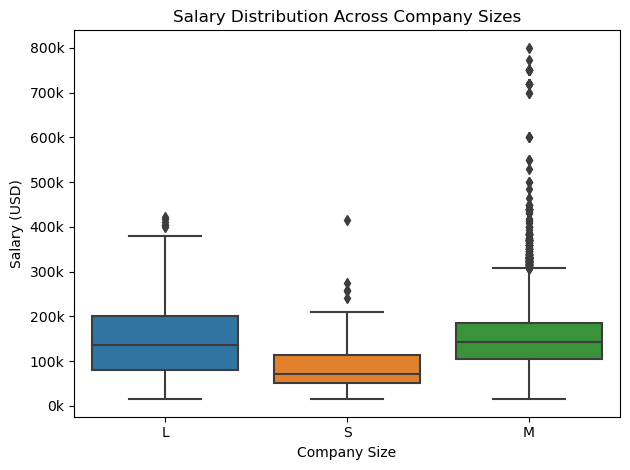

In [64]:
fig, ax = plt.subplots()

sns.boxplot(df, x = 'company_size', y = 'salary_in_usd')

plt.title('Salary Distribution Across Company Sizes')
plt.xlabel('Company Size')
plt.ylabel('Salary (USD)')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _:f'{x/1000:.0f}k'))

plt.tight_layout()

Seems like there's a difference in the salaries of each company size.

In order to check if there's a statistically significant, we need to check: 
1. independence of observations
    - For the sake of reality, each company are independent without overlapping.

2. normality of distribution within each group

3. homogeneity of variances

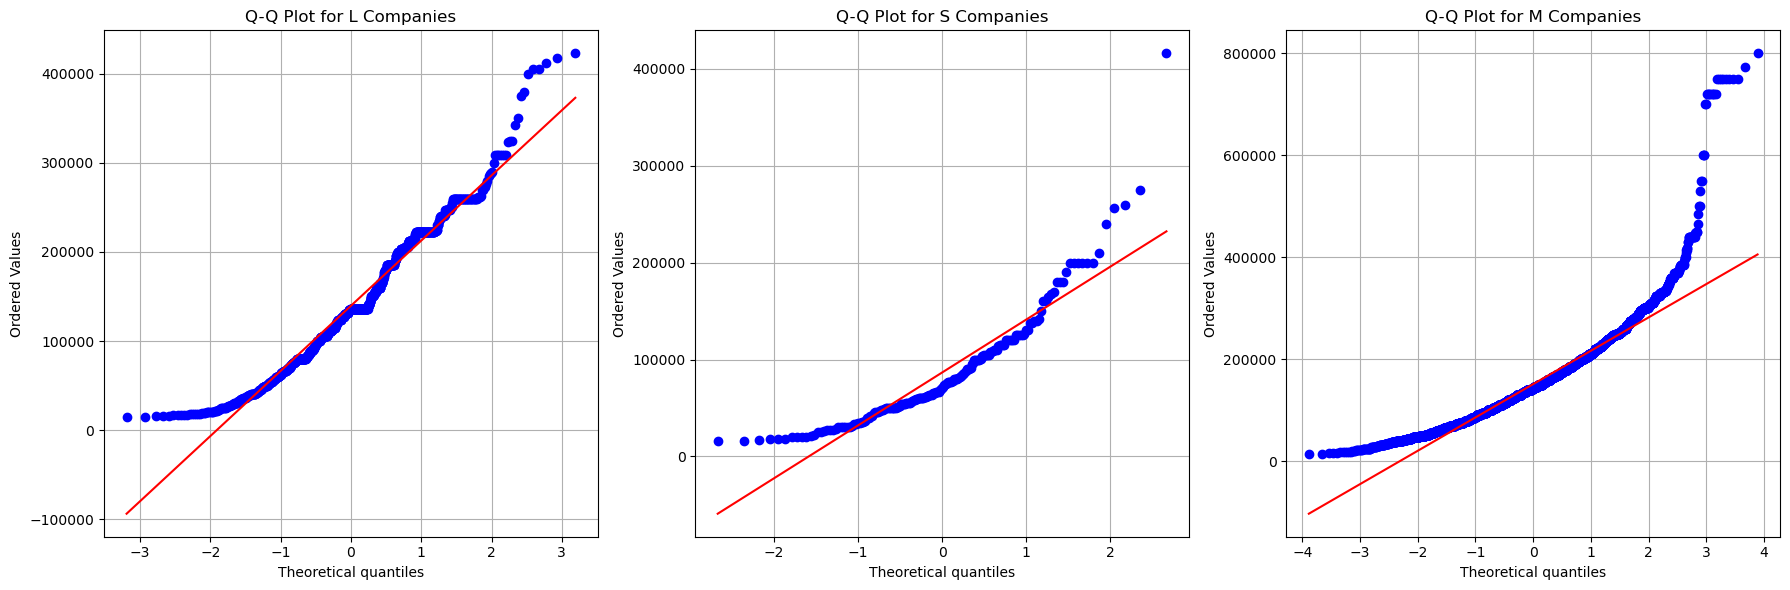

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each company size and plot the Q-Q plots
for i, size in enumerate(df['company_size'].unique()):
    group_data = df[df['company_size'] == size]['salary_in_usd']
    ax = axes[i] 
    
    # Q-Q plot for the current group
    stats.probplot(group_data, dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot for {size} Companies')
    ax.grid(True)
    
plt.tight_layout()
plt.show()

In order to check the normality for the data, we conduct a new hypothesis test and using Z-test:

$H_0$: Data follows normal distribution

$H_1$: Data not follow normal distribution

In [66]:
population_mean = np.mean(df['salary_in_usd'])

for size in df['company_size'].unique():
    group_data = df[df['company_size'] == size]['salary_in_usd']
    n = len(group_data)
    
    print(f'\nZ-test for {size} companies (n={n}):')

    sample_mean = np.mean(group_data)
    sample_std = np.std(group_data, ddof=1) 
    z_statistic = (sample_mean - population_mean) / (sample_std / np.sqrt(n))
        
    print(f'Z-statistic: {z_statistic:.4f}')
        
    # Calculate p-value from the Z-distribution
    p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))  # Two-tailed test
        
    print(f'p-value: {p_value:.4f}')
    
    if p_value < alpha:
        print(f'At {alpha*100}% significance level: Reject the null hypothesis. With {(1-alpha)*100}% confidence, we can conclude that data do not follow normal distribution')
    else:
        print(f'At {alpha*100}% significance level: Fail to reject the null hypothesis. With {(1-alpha)*100}% confidence, we can conclude that data follow normal distribution')



Z-test for L companies (n=983):
Z-statistic: -4.3414
p-value: 0.0000
At 5.0% significance level: Reject the null hypothesis. With 95.0% confidence, we can conclude that data do not follow normal distribution

Z-test for S companies (n=181):
Z-statistic: -14.5479
p-value: 0.0000
At 5.0% significance level: Reject the null hypothesis. With 95.0% confidence, we can conclude that data do not follow normal distribution

Z-test for M companies (n=13674):
Z-statistic: 2.6981
p-value: 0.0070
At 5.0% significance level: Reject the null hypothesis. With 95.0% confidence, we can conclude that data do not follow normal distribution


Thus, there at least one assumption for parameter inference was violated.

Then we need to use non-parametric test: 1-way ANOVA (use median instaed of mean)

Why: non-parametric test are often based on ranks rather than actual values. The median is the natural measure of central tendency for non-normally distributed data because it is robust to outliers adn gives a good sense of the 'middle' of the distribution, espeially when teh data is skewed.



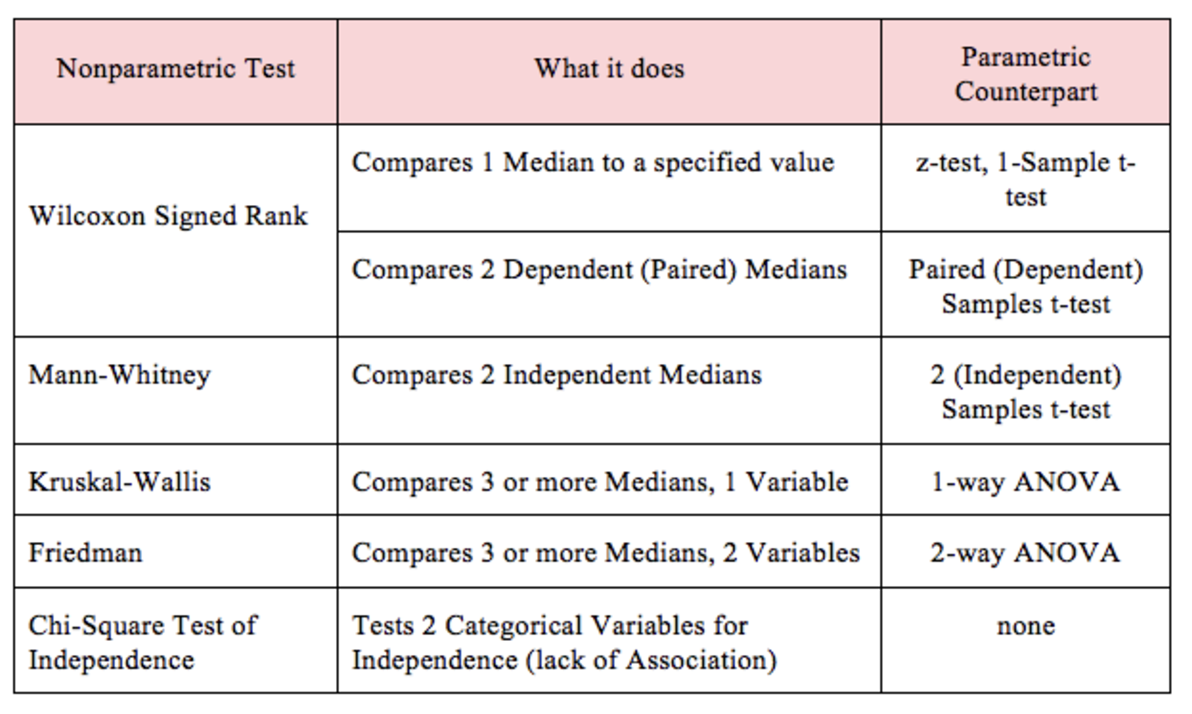

In [67]:
company_size = df['company_size'].unique()

size_groups = [df[df['company_size'] == size]['salary_in_usd'] for size in company_size]

stat, p_value = stats.kruskal(*size_groups)
print(f'1-way ANOVA test: p-value = {p_value:.4f}\n')

if p_value > alpha:
    print(f'Fail to reject the null hypothesis, i.e. we have {(1-alpha)*100}% confidence that there is no difference in salaries between company sizes.')
else:
    print(f'Reject the null hypothesis, i.e. we have {(1-alpha)*100}% confidence that there is a significant difference in salaries between company sizes.')


1-way ANOVA test: p-value = 0.0000

Reject the null hypothesis, i.e. we have 95.0% confidence that there is a significant difference in salaries between company sizes.


Then we use 2 independent t-test to compare 2 independent medians. 

In this case, we randomlly gorup between 'S, M, L' company size in order to apply 2 independent t-test.

In [68]:
for size1, size2 in combinations(['S', 'M', 'L'], 2):
    group1 = df[df['company_size'] == size1]['salary_in_usd']
    group2 = df[df['company_size'] == size2]['salary_in_usd']
    
    stat, p_value = stats.mannwhitneyu(group1, group2)
    print(f'2 independent t-test {size1} vs {size2}: p-value = {p_value:.4f}')

2 independent t-test S vs M: p-value = 0.0000
2 independent t-test S vs L: p-value = 0.0000
2 independent t-test M vs L: p-value = 0.0000


Thus, statistical analysis shows significant differences in salaries across company size (by 1-way ANOVA). With 2-independent t-test as a pairwise comparisons, reveal significant salary differences between all paires of company size (p_value < 0.05).

In conclusion, small, medium and large companies has distinct salary distributions. Therefore, company size is a significant factor incluencing salary structures, with each size category maintaining its own compensation framework.

2. Hypothesis testing on salaries across experience level.

We want to know if there's a significant salary difference across experience level.

$H_0$: There is no statistically siganificant difference in mean salaries among experience level.

$H_1$: There is a statistically siganificant difference in mean salaries among experience level.

By default, $\alpha$ = 0.05

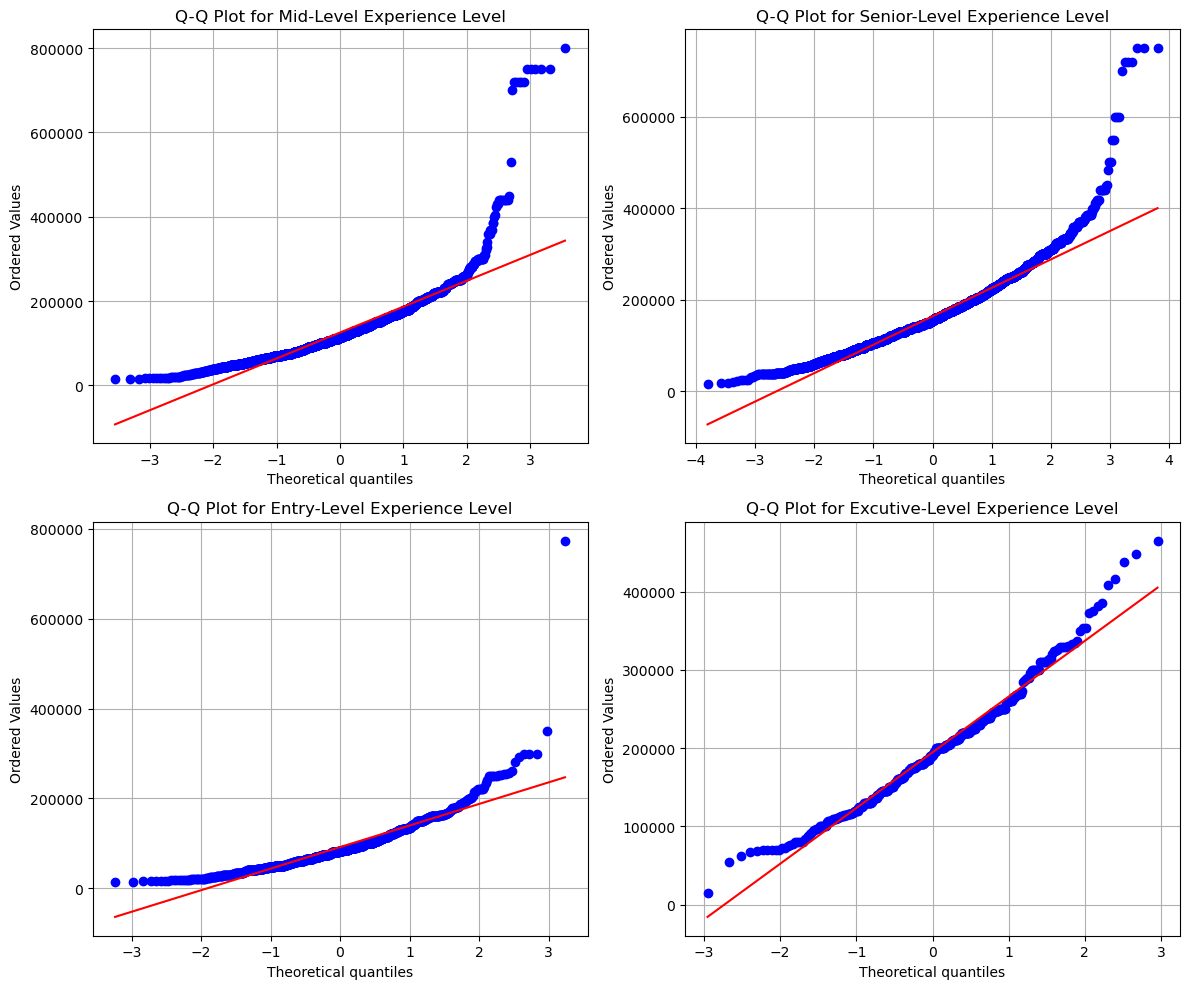

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

for i, level in enumerate(df['experience_level'].unique()):
    group_data = df[df['experience_level'] == level]['salary_in_usd']
    ax = axes[i]
    
    # Q-Q plot for the current experience level
    stats.probplot(group_data, dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot for {level} Experience Level')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [70]:
exp_levels = df['experience_level'].unique()

exp_groups = [df[df['experience_level'] == level]['salary_in_usd'] for level in exp_levels]

# Run Kruskal-Wallis H-test for salary differences across experience levels
stat, p_value = stats.kruskal(*exp_groups)
print(f'Kruskal-Wallis test for salary vs. experience level: p-value = {p_value:.4f} \n')

alpha = 0.05

if p_value > alpha:
    print(f'Fail to reject the Null Hypothesis. No significant difference in salaries across experience levels: {exp_levels}.')
else:
    print(f'Reject the Null Hypothesis. There is a significant difference in salaries across experience levels: {exp_levels}.')

Kruskal-Wallis test for salary vs. experience level: p-value = 0.0000 

Reject the Null Hypothesis. There is a significant difference in salaries across experience levels: ['Mid-Level' 'Senior-Level' 'Entry-Level' 'Excutive-Level'].


In [71]:
# Kruskal-Wallis U test is significant, perform pairwise comparisons
if p_value < alpha:
    print("\nPairwise comparisons using Mann-Whitney U tests:")
    
    for i, level1 in enumerate(exp_levels):
        for level2 in exp_levels[i+1:]:
            group1 = df[df['experience_level'] == level1]['salary_in_usd']
            group2 = df[df['experience_level'] == level2]['salary_in_usd']
            
            u_stat, p_value_u = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            print(f'{level1} vs {level2}: p-value = {p_value_u:.4f}')
            
            if p_value_u < alpha:
                print(f"  Significant difference between {level1} and {level2} at α = {alpha}.")
            else:
                print(f"  No significant difference between {level1} and {level2} at α = {alpha}.")


Pairwise comparisons using Mann-Whitney U tests:
Mid-Level vs Senior-Level: p-value = 0.0000
  Significant difference between Mid-Level and Senior-Level at α = 0.05.
Mid-Level vs Entry-Level: p-value = 0.0000
  Significant difference between Mid-Level and Entry-Level at α = 0.05.
Mid-Level vs Excutive-Level: p-value = 0.0000
  Significant difference between Mid-Level and Excutive-Level at α = 0.05.
Senior-Level vs Entry-Level: p-value = 0.0000
  Significant difference between Senior-Level and Entry-Level at α = 0.05.
Senior-Level vs Excutive-Level: p-value = 0.0000
  Significant difference between Senior-Level and Excutive-Level at α = 0.05.
Entry-Level vs Excutive-Level: p-value = 0.0000
  Significant difference between Entry-Level and Excutive-Level at α = 0.05.


Statistical analysis indicates a significant difference in salaries across different experience levels (Kruskal-Wallis test, p < 0.05). Pairwise comparisons using Mann-Whitney U tests show significant differences between each pair of experience levels.

These findings strongly suggest that experience level plays a critical role in determining salary, with significant disparities observed across all experience levels in the dataset.

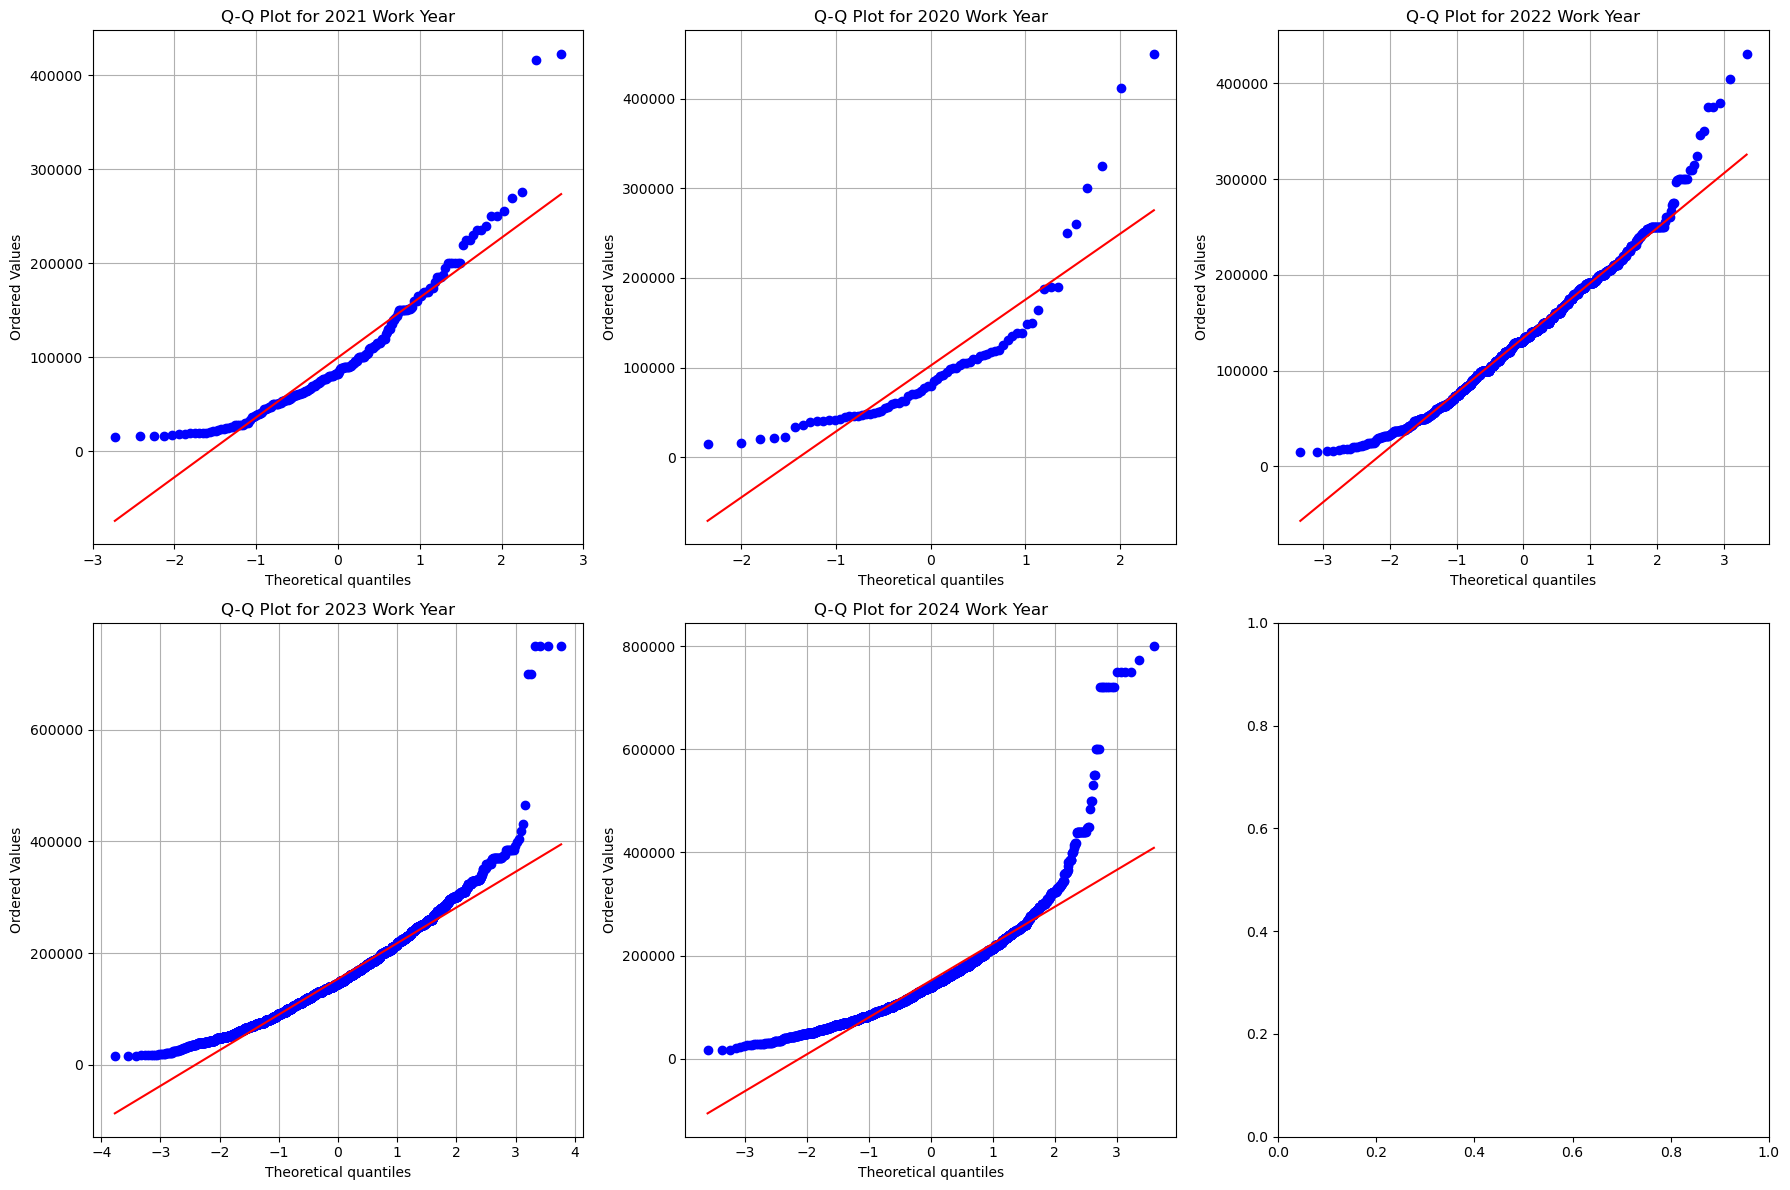

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid for Q-Q plots
axes = axes.flatten()

for i, year in enumerate(df['work_year'].unique()):
    group_data = df[df['work_year'] == year]['salary_in_usd']
    ax = axes[i]
    
    # Q-Q plot for the current year
    stats.probplot(group_data, dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot for {year} Work Year')
    ax.grid(True)
    
plt.tight_layout()
plt.show()

In [73]:
work_year_groups = [df[df['work_year'] == year]['salary_in_usd'] for year in df['work_year'].unique()]

stat, p_value = stats.kruskal(*work_year_groups)

print(f'Kruskal-Wallis test for salary vs. work year: p-value = {p_value:.4f}\n')

if p_value > alpha:
    print(f'Fail to reject the Null Hypothesis. There is no significant difference in salaries across work years: {df["work_year"].unique()}.')
else:
    print(f'Reject the Null Hypothesis. There is a significant difference in salaries across work years: {df["work_year"].unique()}.')

Kruskal-Wallis test for salary vs. work year: p-value = 0.0000

Reject the Null Hypothesis. There is a significant difference in salaries across work years: [2021 2020 2022 2023 2024].


In [74]:
years = df['work_year'].unique()

for i in range(len(years)):
    for j in range(i + 1, len(years)):
        group1 = df[df['work_year'] == years[i]]['salary_in_usd']
        group2 = df[df['work_year'] == years[j]]['salary_in_usd']
            
        u_stat, p_val = stats.mannwhitneyu(group1, group2)
        print(f'{years[i]} vs {years[j]}: p-value = {p_val:.4f}')
            
        if p_val < alpha:
            print(f'  Significant difference between {years[i]} and {years[j]} at α = {alpha}.')
        else:
            print(f'  No significant difference between {years[i]} and {years[j]} at α = {alpha}.')

2021 vs 2020: p-value = 0.6754
  No significant difference between 2021 and 2020 at α = 0.05.
2021 vs 2022: p-value = 0.0000
  Significant difference between 2021 and 2022 at α = 0.05.
2021 vs 2023: p-value = 0.0000
  Significant difference between 2021 and 2023 at α = 0.05.
2021 vs 2024: p-value = 0.0000
  Significant difference between 2021 and 2024 at α = 0.05.
2020 vs 2022: p-value = 0.0000
  Significant difference between 2020 and 2022 at α = 0.05.
2020 vs 2023: p-value = 0.0000
  Significant difference between 2020 and 2023 at α = 0.05.
2020 vs 2024: p-value = 0.0000
  Significant difference between 2020 and 2024 at α = 0.05.
2022 vs 2023: p-value = 0.0000
  Significant difference between 2022 and 2023 at α = 0.05.
2022 vs 2024: p-value = 0.0000
  Significant difference between 2022 and 2024 at α = 0.05.
2023 vs 2024: p-value = 0.0000
  Significant difference between 2023 and 2024 at α = 0.05.


We can see:
    
    1.No significant difference: Between 2021 and 2020.

    2.Significant differences: Between all other year pairs (2021 vs 2022, 2021 vs 2023, 2021 vs 2024, etc.).
    

These findings suggest that salary trends have varied notably over the years, with differences becoming significant between most work years, except for 2021 and 2020.

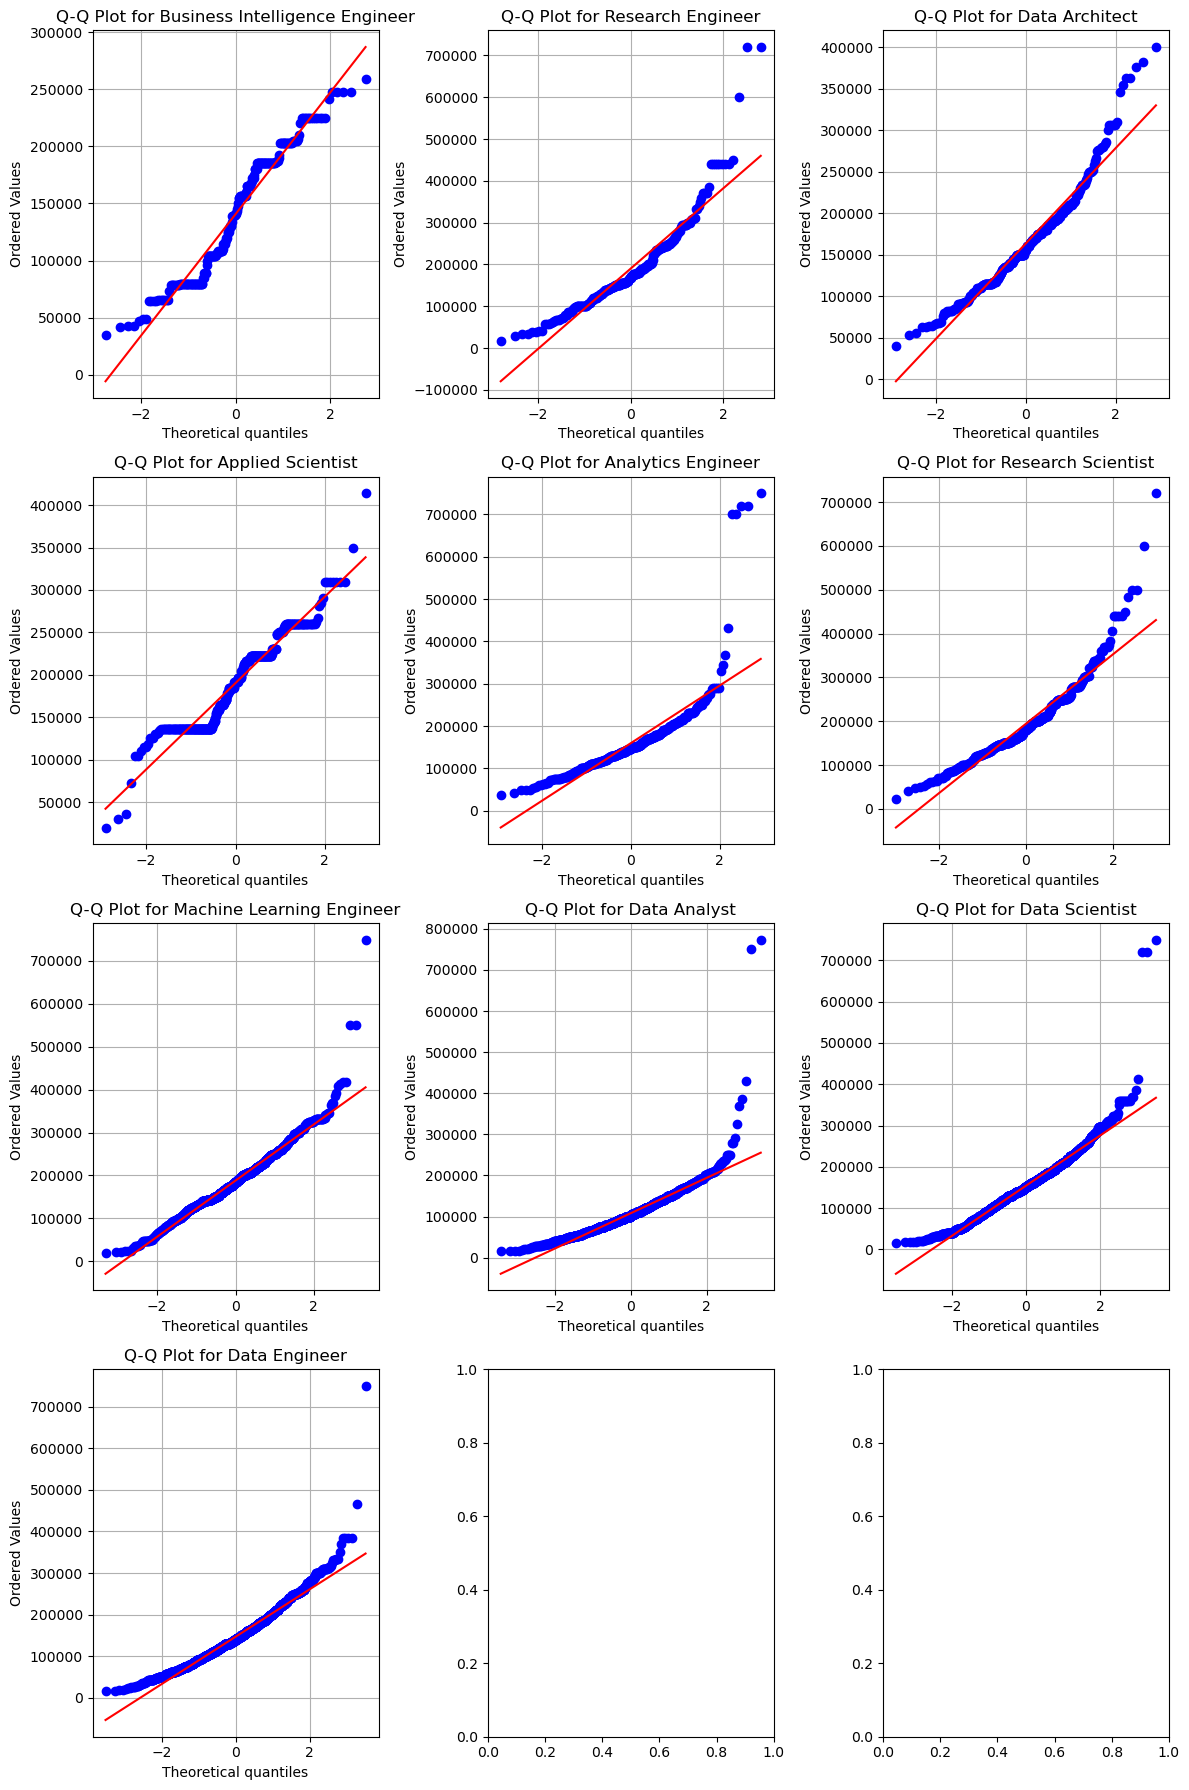

In [75]:
fig, axes = plt.subplots(4, 3, figsize=(12, 18))
axes = axes.flatten()

for i, title in enumerate(top10.index):
    group_data = df[df['job_title'] == title]['salary_in_usd']
    ax = axes[i]
    
    # Q-Q plot for the current job title
    stats.probplot(group_data, dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot for {title}')
    ax.grid(True) 

plt.tight_layout()
plt.show()

In [76]:
stat, p_value = stats.kruskal(*[df[df['job_title'] == title]['salary_in_usd'] for title in top10.index])

print(f'Kruskal-Wallis test for salary vs. job title: p-value = {p_value:.4f}\n')

if p_value < 0.05:
    print(f'Reject the Null Hypothesis. There is a significant difference in salaries across job titles.')
else:
    print(f'Fail to reject the Null Hypothesis. There is no significant difference in salaries across job titles:.')

Kruskal-Wallis test for salary vs. job title: p-value = 0.0000

Reject the Null Hypothesis. There is a significant difference in salaries across job titles.


In [77]:
# only focus on no significant difference
# Pairwise comparisons using Mann-Whitney U tests
for i, title1 in enumerate(top10.index):
    for title2 in top10.index[i+1:]:
        group1 = df[df['job_title'] == title1]['salary_in_usd']
        group2 = df[df['job_title'] == title2]['salary_in_usd']
        
        # Mann-Whitney U test
        u_statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        
        if p_value > 0.05:
            print(f'No significant difference between \n {title1} and {title2} at α = 0.05.')

No significant difference between 
 Business Intelligence Engineer and Data Engineer at α = 0.05.
No significant difference between 
 Research Engineer and Research Scientist at α = 0.05.
No significant difference between 
 Research Engineer and Machine Learning Engineer at α = 0.05.
No significant difference between 
 Applied Scientist and Research Scientist at α = 0.05.
No significant difference between 
 Applied Scientist and Machine Learning Engineer at α = 0.05.
No significant difference between 
 Analytics Engineer and Data Scientist at α = 0.05.
No significant difference between 
 Research Scientist and Machine Learning Engineer at α = 0.05.


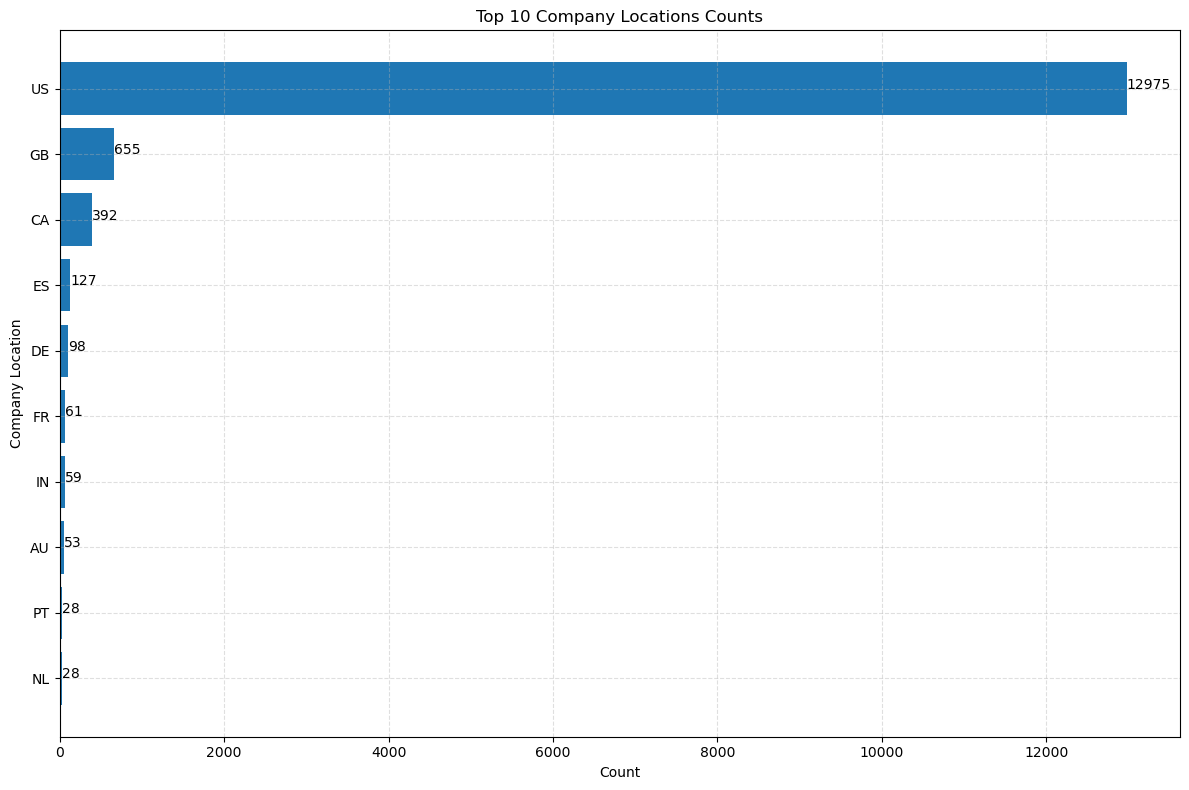

In [78]:
top10_locations = df['company_location'].value_counts()[:10].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(top10_locations.index, top10_locations.values)
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.0f}')

ax.set_title('Top 10 Company Locations Counts')
ax.set_xlabel('Count')
ax.set_ylabel('Company Location')
ax.grid(linestyle='--', alpha=.4)
plt.tight_layout()
plt.show()

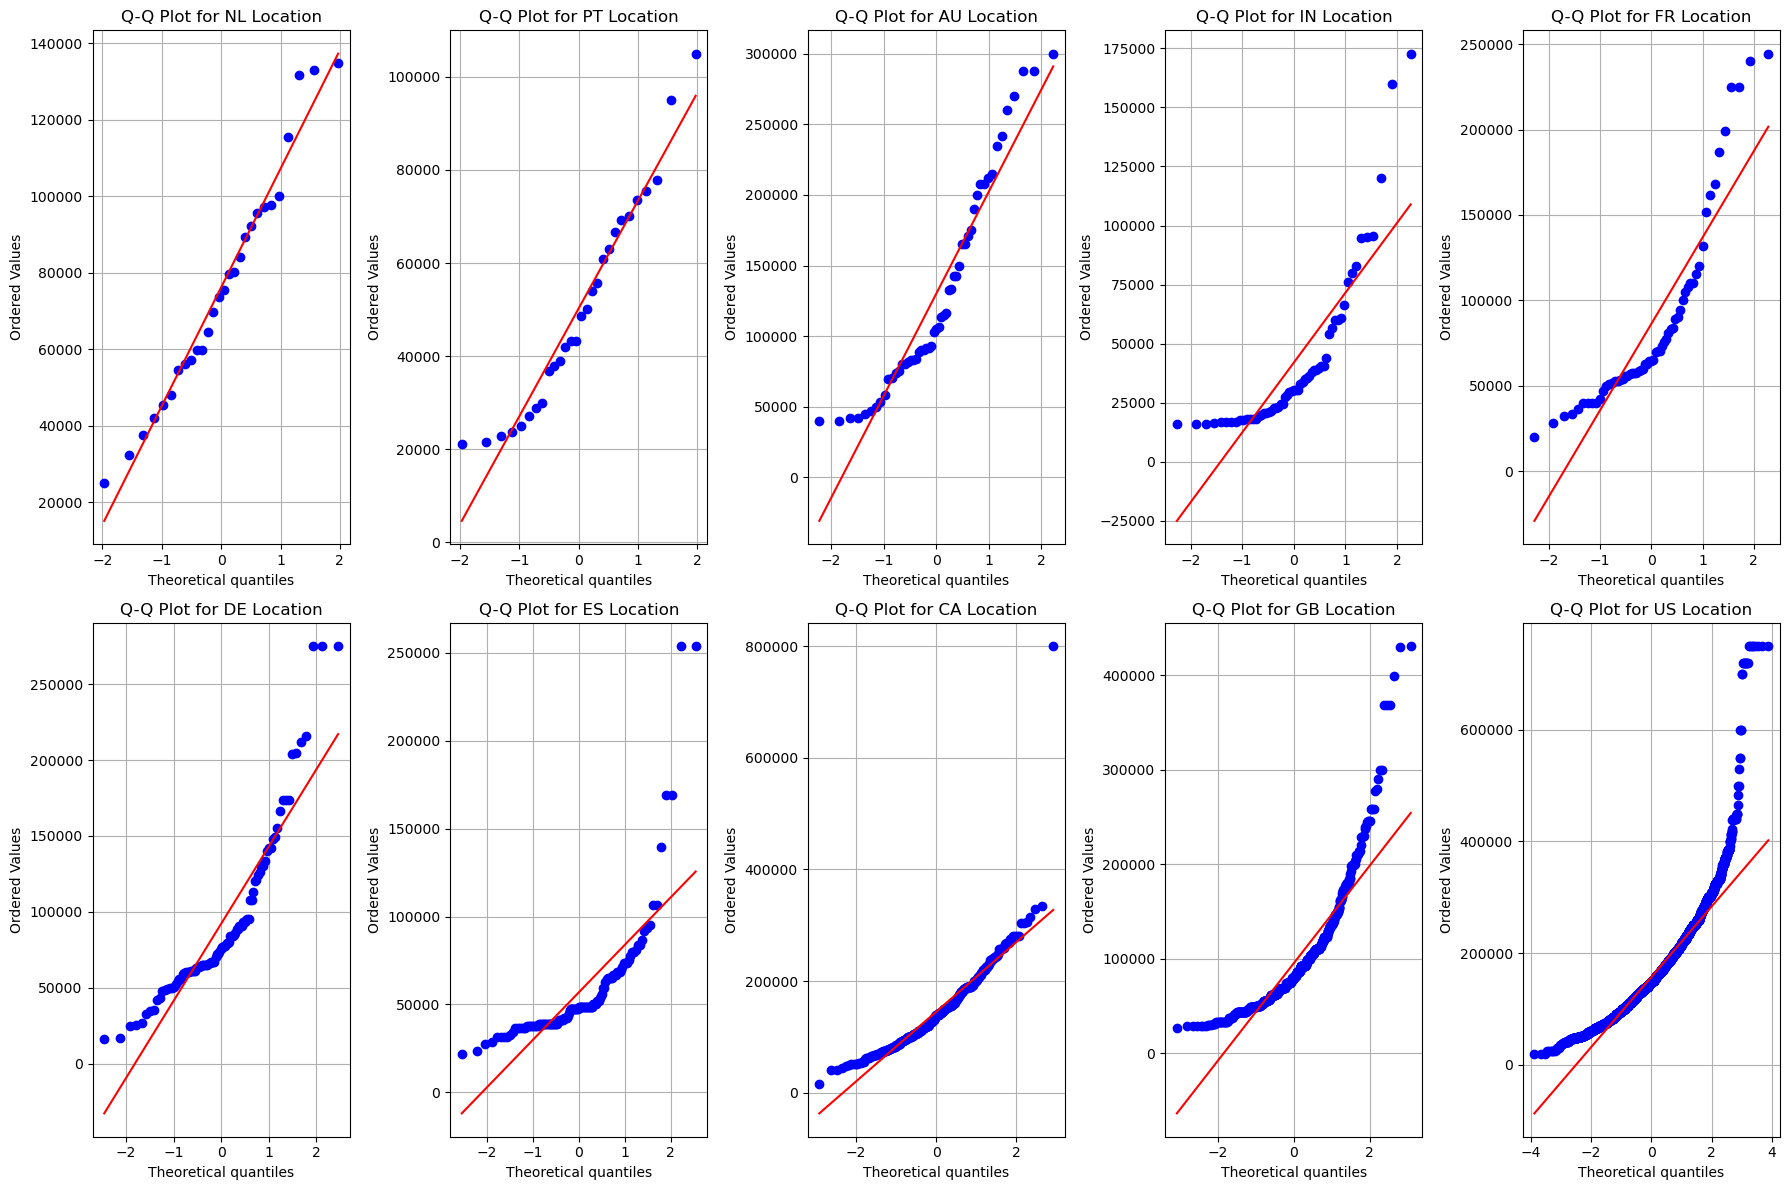

In [79]:
top_10_locations = top10_locations.index

fig, axes = plt.subplots(2, 5, figsize=(18, 12))
axes = axes.flatten()

for i, location in enumerate(top_10_locations):
    group_data = df[df['company_location'] == location]['salary_in_usd']
    ax = axes[i]
    
    stats.probplot(group_data, dist='norm', plot=ax)
    ax.set_title(f'Q-Q Plot for {location} Location')
    ax.grid(True) 
    
plt.tight_layout()
plt.show()

In [80]:
# Perform Kruskal-Wallis test for salary vs company location
stat, p_value = stats.kruskal(*[df[df['company_location'] == location]['salary_in_usd'] for location in top_10_locations])

print(f'Kruskal-Wallis test for salary vs. company location: p-value = {p_value:.4f}\n')

if p_value < alpha:
    print(f'Reject the Null Hypothesis. There is a significant difference in salaries across company locations.')
else:
    print(f'Fail to reject the Null Hypothesis. There is no significant difference in salaries across company locations.')

Kruskal-Wallis test for salary vs. company location: p-value = 0.0000

Reject the Null Hypothesis. There is a significant difference in salaries across company locations.


In [81]:
# Pairwise comparisons using Mann-Whitney U tests
for i, location1 in enumerate(top_10_locations):
    for location2 in top_10_locations[i+1:]:
        group1 = df[df['company_location'] == location1]['salary_in_usd']
        group2 = df[df['company_location'] == location2]['salary_in_usd']
        
        u_statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        
        if p_value > alpha:
            print(f'  No significant difference between {location1} and {location2} at α = 0.05.')

  No significant difference between NL and FR at α = 0.05.
  No significant difference between NL and DE at α = 0.05.
  No significant difference between NL and GB at α = 0.05.
  No significant difference between PT and ES at α = 0.05.
  No significant difference between FR and DE at α = 0.05.
  No significant difference between FR and GB at α = 0.05.
  No significant difference between DE and GB at α = 0.05.


In [82]:
top10_titles = df['job_title'].value_counts().index[:10]
top10_df = df[df['job_title'].isin(top10_titles)]

# Enable JSON transformer
alt.data_transformers.enable("json")

# Create the chart
chart = alt.Chart(top10_df).mark_bar().encode(
    x=alt.X('salary_in_usd:Q', bin=alt.Bin(maxbins=20), title='Salary (USD)'),
    y=alt.Y('count()', title='Count'),
    color='job_title:N',
    tooltip=['job_title', 'experience_level', 'salary_in_usd']
).properties(
    width=800,
    height=400,
    title='Salary Distribution by Job Title and Experience Level'
).interactive()

# Show the chart
chart.show()


alt.Chart(...)

In [83]:
# Interactive facet grid with Plotly
fig = px.scatter(
    top10_df,
    x='work_year',
    y='salary_in_usd',
    color='job_title',
    facet_col='experience_level',
    hover_data=['company_location', 'company_size'], 
    title='Salary Trends by Work Year and Experience Level',
    labels={'salary_in_usd': 'Salary (USD)', 'work_year': 'Work Year'},
)

fig.update_layout(
    legend_title_text='Job Title',
    xaxis_title='Work Year',
    yaxis_title='Salary (USD)',
    width=1200,  # Adjust width
    height=800,   # Adjust height
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
fig.show()


In [84]:
df

work_year experience_level employment_type  \
0           2021        Mid-Level       Full-Time   
1           2021        Mid-Level       Full-Time   
2           2020        Mid-Level       Full-Time   
3           2021        Mid-Level       Full-Time   
4           2022     Senior-Level       Full-Time   
...          ...              ...             ...   
14833       2022        Mid-Level       Full-Time   
14834       2020   Excutive-Level       Full-Time   
14835       2021      Entry-Level       Full-Time   
14836       2022      Entry-Level       Full-Time   
14837       2020      Entry-Level       Part-Time   

                             job_title    salary salary_currency  \
0                       Data Scientist  30400000             CLP   
1                      BI Data Analyst  11000000             HUF   
2                       Data Scientist  11000000             HUF   
3                          ML Engineer   8500000             JPY   
4       Lead Machine Learning Engineer   7500000             INR   
...                                ...       ...             ...   
14833  Business Intelligence Developer     15000             USD   
14834               Staff Data Analyst     15000             USD   
14835       Machine Learning Developer     15000             USD   
14836                     Data Analyst     15000             USD   
14837                      ML Engineer     14000             EUR   

       salary_in_usd employee_residence  remote_ratio company_location  \
0              40038                 CL           100               CL   
1              36259                 HU            50               US   
2              35735                 HU            50               HU   
3              77364                 JP            50               JP   
4              95386                 IN            50               IN   
...              ...                ...           ...              ...   
14833          15000                 GH           100               GH   
14834          15000                 NG             0               CA   
14835          15000                 TH           100               TH   
14836          15000                 ID             0               ID   
14837          15966                 DE           100               DE   

      company_size  
0                L  
1                L  
2                L  
3                S  
4                L  
...            ...  
14833            M  
14834            M  
14835            L  
14836            L  
14837            S  

[14838 rows x 11 columns]

### Step 1: Clean up & Select data 

Ignorning `salary`, `salary_currency`, `work_year`, meaningless categorical data.

Then only `salary_in_usd` is the numerical columns, but it has some significant outliers that affect the model, thus we use log transformation `salary_in_usd_log`to reduce the effect of extreme values and make the distribution more normal.

In order to used in machine learning models, we need to convert categorical columns to numerical values using LabelEncoder (scikit-learn)

For the sake of reality, we also drop `company_location`, or the ML model will look like that

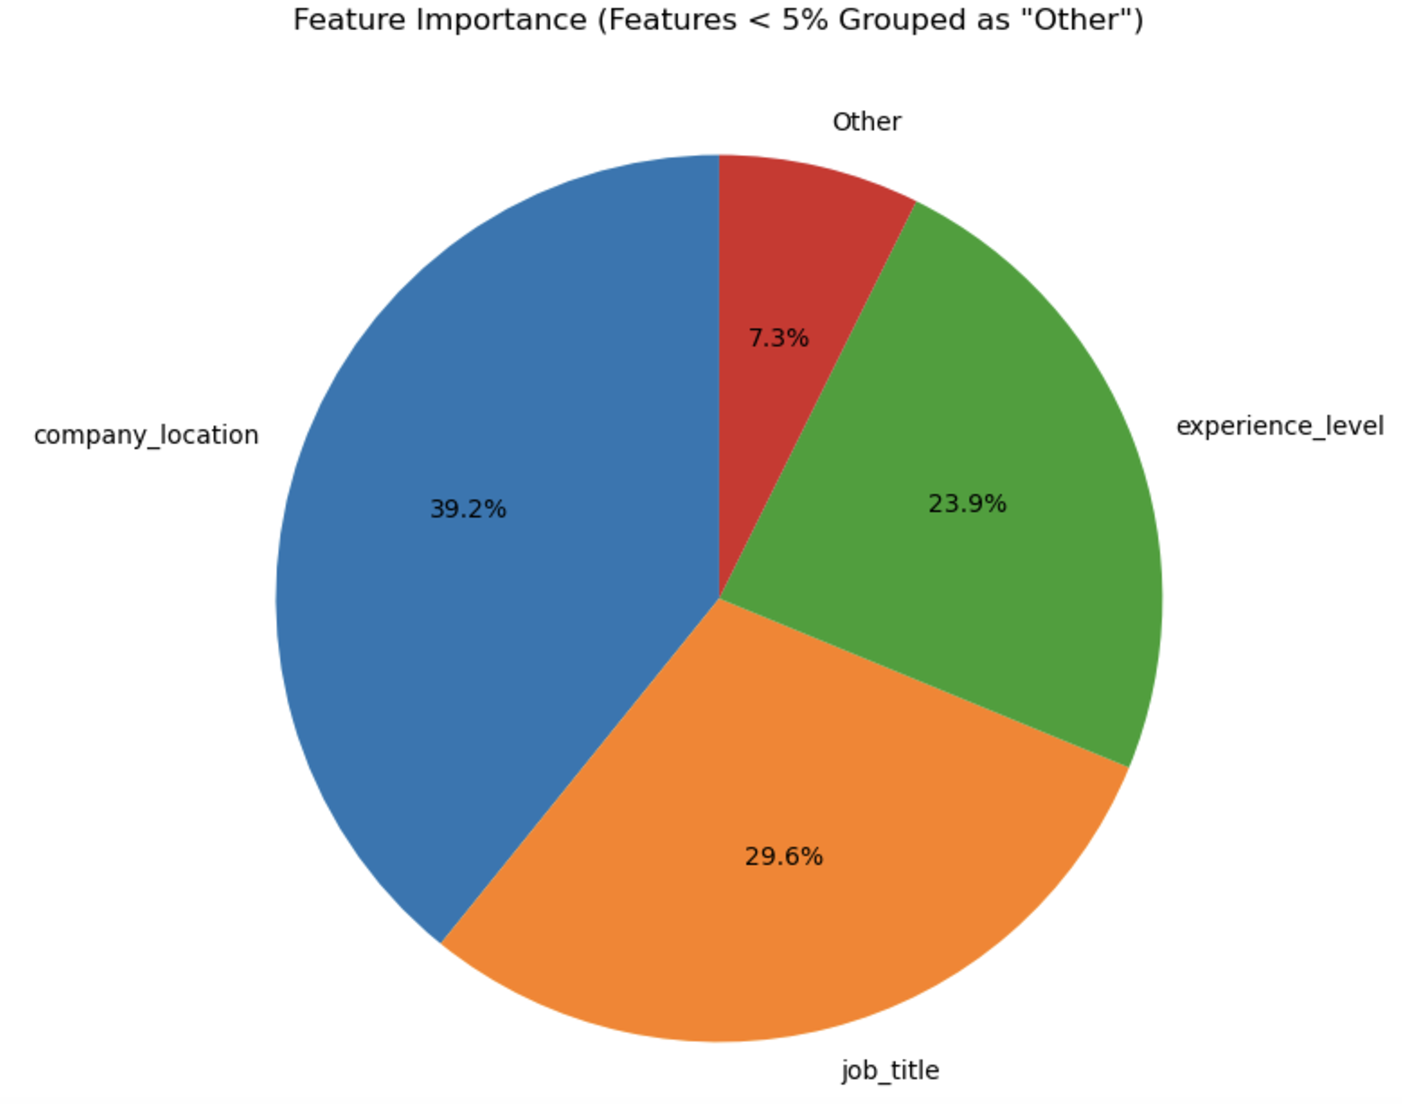

Same idea with `employee_residence`

In [85]:
label_encoders = {}
categorical_columns = ['experience_level', 'employment_type', 'job_title', 
                        'company_size', 'remote_ratio']

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])
    
df['salary_in_usd_log'] = np.log(df['salary_in_usd'])

for col, le in label_encoders.items():
    print(f"\nColumn: {col}")
    mapping = {idx: label for idx, label in enumerate(le.classes_)}  # Use classes_ for proper mapping
    for encoded_val, original_val in mapping.items():
        print(f"{encoded_val}: {original_val}")



Column: experience_level
0: Entry-Level
1: Excutive-Level
2: Mid-Level
3: Senior-Level

Column: employment_type
0: Contract
1: Freelance
2: Full-Time
3: Part-Time

Column: job_title
0: AI Architect
1: AI Developer
2: AI Engineer
3: AI Product Manager
4: AI Programmer
5: AI Research Engineer
6: AI Research Scientist
7: AI Scientist
8: AI Software Engineer
9: AWS Data Architect
10: Admin & Data Analyst
11: Analytics Engineer
12: Analytics Engineering Manager
13: Applied Data Scientist
14: Applied Machine Learning Engineer
15: Applied Machine Learning Scientist
16: Applied Research Scientist
17: Applied Scientist
18: Autonomous Vehicle Technician
19: Azure Data Engineer
20: BI Analyst
21: BI Data Analyst
22: BI Data Engineer
23: BI Developer
24: Big Data Architect
25: Big Data Developer
26: Big Data Engineer
27: Business Data Analyst
28: Business Intelligence
29: Business Intelligence Analyst
30: Business Intelligence Data Analyst
31: Business Intelligence Developer
32: Business Intellig

### Step 2: Data preparation

`train_test_split`: randomly splits dataset into training and test set based on `test_size`, with 20% used for testing, 80% for training.

`random_state`: ensure ML consistent.

`StandardScaler()`: standardize the data by removing the mean and scaling to unit variance, helps improve ML algorithms.

`fit_transform()`, `transform()`: avoid data leakage.

In [86]:
# Features (independent variables) and target (dependent variable)
X = df[['experience_level', 'employment_type', 'job_title', 'company_size', 'remote_ratio']]
y = df['salary_in_usd_log']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 3: Training Model

`RandomForestRegressor`: ML model for regression task. Creates decision trees and average predictions.

`n_estimators`: specifies the number of tress in the forest, in thise case, we set 100 decision tress in the forest.

Model trained on the scaled training data: X_train_scaled, y_train.

Then perdict salaries (y_pred) based on the testing data (X_test_scaled)

Mean Absolute Error (MAE): measures the average absolute difference between predicted and actual values, smaller value indicates better performance
$$
MAE = \frac{1}{n}\sum_{i=1}^{n}|(y_i - \hat y_i)|
$$

Mean Squared Error (MSE): average squared differences between the predicted and actual values
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat y_i)^2
$$

RMSE = $\sqrt MSE $, more sensitive to large errors because of the differences

In [87]:
# Training the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_log = model.predict(X_test_scaled)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"Mean Absolute Error (MAE): {mae:.2f} USD")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")

# Convert log-salaries back to the original scale
y_pred_original = np.exp(y_pred_log)
y_test_original = np.exp(y_test)

Mean Absolute Error (MAE): 0.30 USD
Root Mean Squared Error (RMSE): 0.40 USD


Meaning that the differences between the predicted and actural is 0.3USD with MAE, 0.4USD with RMSE.

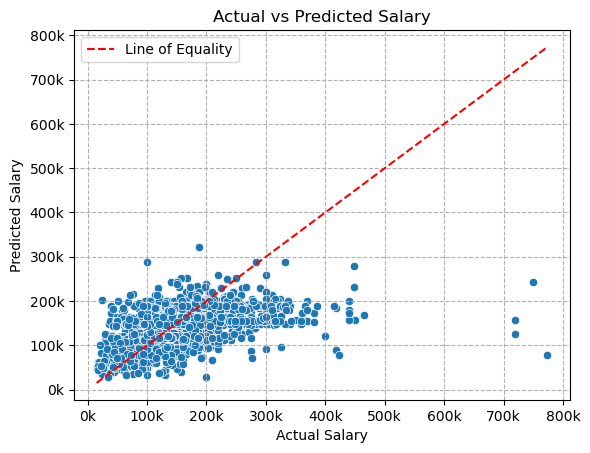

In [88]:
y_pred_original = np.exp(y_pred_log)
y_test_original = np.exp(y_test)

def thousands_formatter(x, pos): return f'{x/1000:.0f}k'

sns.scatterplot(x=y_test_original, y=y_pred_original)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salary')

# Add the line of equality (diagonal line where x = y)
min_value = min(np.min(y_test_original), np.min(y_pred_original))
max_value = max(np.max(y_test_original), np.max(y_pred_original))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

# Formatting the axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.grid(True, linestyle='--')
plt.legend()
plt.show()

In [89]:
# Calculate the absolute error between actual and predicted values
absolute_error = np.abs(y_test_original - y_pred_original)

# Define a tolerance, in this case, set 0.8 since 80% training
tolerance = 0.80

acceptable_error = y_test_original * tolerance
correct_predictions = np.sum(absolute_error <= acceptable_error)
percentage_correct = (correct_predictions / len(y_test_original)) * 100

print(f"Percentage of predictions within {tolerance*100}% of the actual values: {percentage_correct:.2f}%")

Percentage of predictions within 80.0% of the actual values: 93.43%


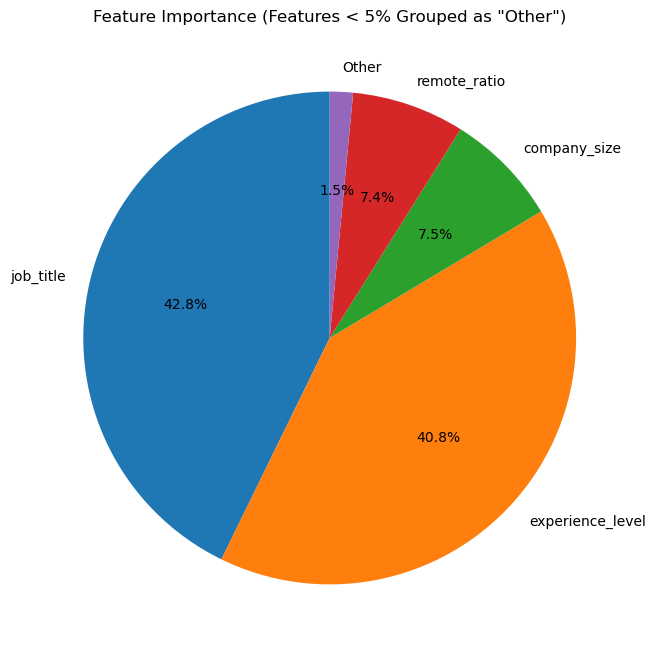

In [90]:
# Get feature importances from the trained model
importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Filter out features with less than 5% importance
threshold = 0.05
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]
other_features = feature_importance_df[feature_importance_df['Importance'] < threshold]

# Create a new "Other" category for the small features
other_sum = other_features['Importance'].sum()

# Concatenate 'Other' category with the important features DataFrame
other_df = pd.DataFrame({'Feature': ['Other'], 'Importance': [other_sum]})
important_features = pd.concat([important_features, other_df], ignore_index=True)

# Plotting the pie chart
plt.figure(figsize=(8,8))
plt.pie(important_features['Importance'], labels=important_features['Feature'], autopct='%1.1f%%', startangle=90)
plt.title('Feature Importance (Features < 5% Grouped as "Other")')
plt.show()


### Now we can apply to Optimizing Job Offers

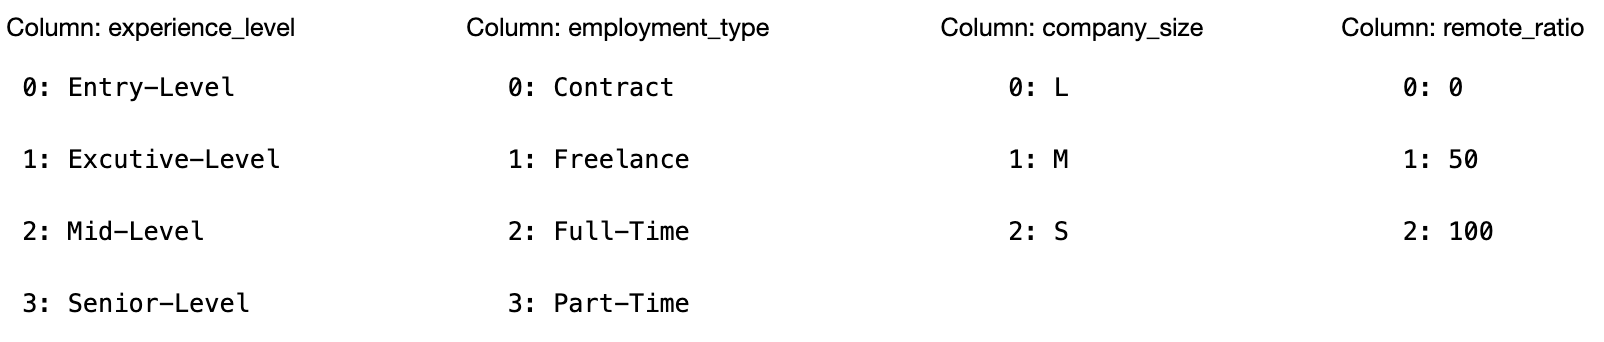

In [91]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

XGBoost MAE: 0.30, RMSE: 0.40


In [92]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
}

# Grid search
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [93]:
# Train the model with the best parameters
best_xgb_model = XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=100, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.30
RMSE: 0.39


In [148]:
accuracy_threshold = 0.10 
within_threshold = np.abs(y_pred - y_test) / y_test <= accuracy_threshold
accuracy = np.mean(within_threshold) * 100  
print(f"Accuracy within ±10%: {accuracy:.2f}%")

Accuracy within ±10%: 98.18%


In [149]:
input_data_encoded = {
    'experience_level': 0,  
    'employment_type': 2, 
    'job_title': 143,
    'company_size': 2,    
    'remote_ratio': 1 
}

In [150]:
input_df = pd.DataFrame([input_data_encoded])
input_scaled = scaler.transform(input_df)

predicted_log_salary = best_xgb_model.predict(input_scaled)
predicted_salary = np.exp(predicted_log_salary)

print(f"Predicted Salary Package: ${predicted_salary[0]:,.2f}")

Predicted Salary Package: $68,447.84


But it looks too superficial, thus we modefied our model with creating a new model which can predict the salary few years later.

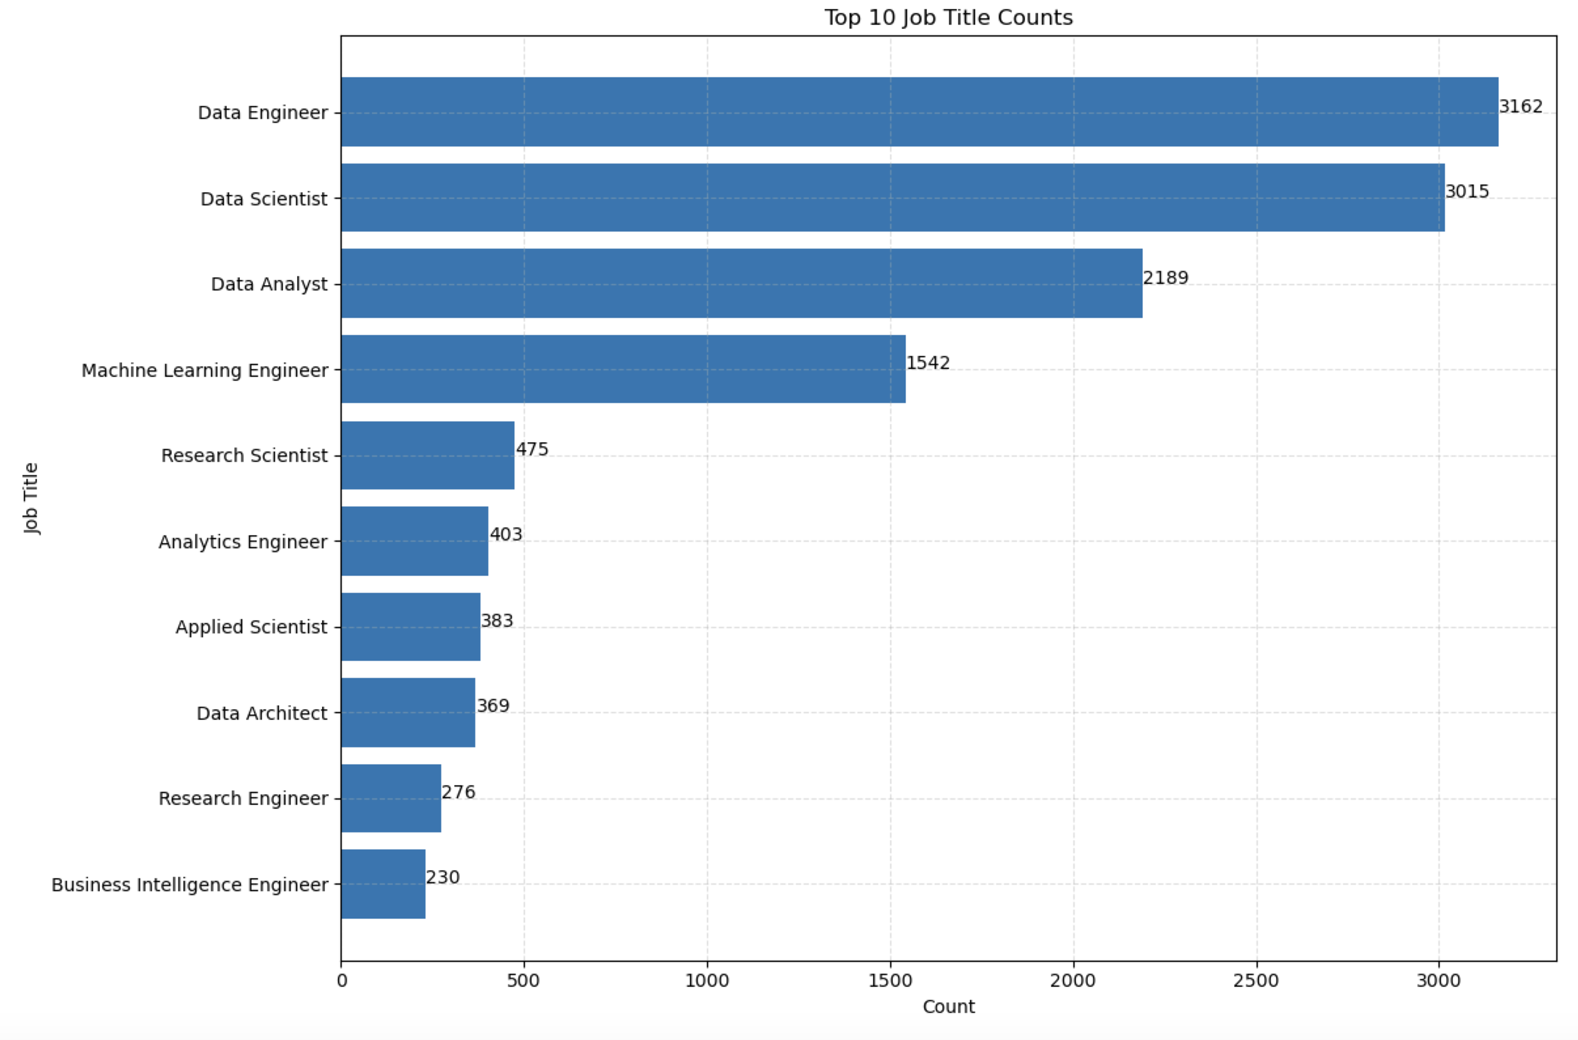

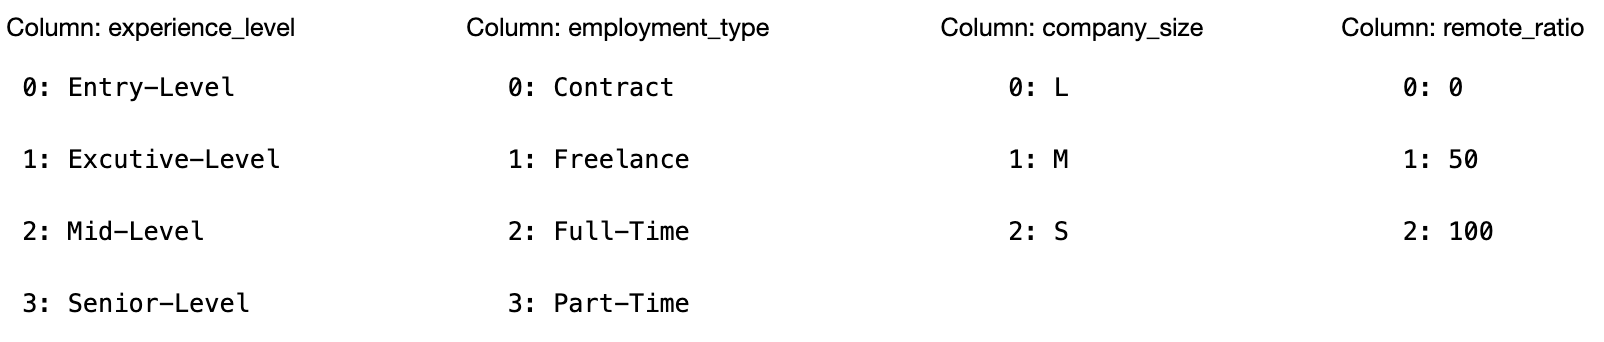

In [143]:
# Mid-Level, Full-time, company M, on-site
input_job_title_decoded = 'Data Engineer'

input_data = {
    'experience_level': 2,  
    'employment_type': 2,  
    'job_title': label_encoders['job_title'].transform([input_job_title_decoded])[0],
    'company_size': 1,    
    'remote_ratio': 0 
}


In [100]:
# # Mid-Level, Full-time, company M, on-site 
# input_job_title_decoded = 'Data Scientist'
# a
# input_data = {
#     'experience_level': 2,  
#     'employment_type': 2,  
#     'job_title': label_encoders['job_title'].transform([input_job_title_decoded])[0],
#     'company_size': 1,    
#     'remote_ratio': 0 
# }

In [101]:
# # Mid-Level, Full-time, company M, on-site 
# input_job_title_decoded = 'Data Analyst'

# input_data = {
#     'experience_level': 2,  
#     'employment_type': 2,  
#     'job_title': label_encoders['job_title'].transform([input_job_title_decoded])[0],
#     'company_size': 1,    
#     'remote_ratio': 0 
# }


In [102]:
# input_job_title_decoded = 'Data Analyst'

# input_data = {
#     'experience_level': 0,  
#     'employment_type': 2,  
#     'job_title': label_encoders['job_title'].transform([input_job_title_decoded])[0],
#     'company_size': 0,    
#     'remote_ratio': 0
# }


In [144]:
filtered_df = df[
    (df['experience_level'] == input_data['experience_level']) &
    (df['employment_type'] == input_data['employment_type']) &
    (df['job_title'] == input_data['job_title']) &
    (df['company_size'] == input_data['company_size']) &
    (df['remote_ratio'] == input_data['remote_ratio'])
]
filtered_df

work_year  experience_level  employment_type  job_title  salary  \
75          2023                 2                2         56  750000   
374         2024                 2                2         56  308000   
724         2023                 2                2         56  275000   
757         2024                 2                2         56  270250   
910         2023                 2                2         56  260000   
...          ...               ...              ...        ...     ...   
14685       2024                 2                2         56   34940   
14707       2023                 2                2         56   32000   
14749       2024                 2                2         56   27000   
14786       2022                 2                2         56   24000   
14787       2022                 2                2         56   24000   

      salary_currency  salary_in_usd employee_residence  remote_ratio  \
75                USD         750000                 US             0   
374               USD         308000                 US             0   
724               USD         275000                 CA             0   
757               USD         270250                 US             0   
910               USD         260000                 US             0   
...               ...            ...                ...           ...   
14685             GBP          43675                 US             0   
14707             GBP          39372                 GB             0   
14749             GBP          33750                 GB             0   
14786             USD          24000                 US             0   
14787             USD          24000                 US             0   

      company_location  company_size  salary_in_usd_log  
75                  US             1          13.527828  
374                 US             1          12.637855  
724                 CA             1          12.524526  
757                 US             1          12.507103  
910                 US             1          12.468437  
...                ...           ...                ...  
14685               US             1          10.684531  
14707               GB             1          10.580810  
14749               GB             1          10.426736  
14786               US             1          10.085809  
14787               US             1          10.085809  

[528 rows x 12 columns]

In [145]:
if filtered_df.empty:
    print(f"No data found matching the specified conditions: {input_data}.")
else:
    # mean salary by year
    mean_salary_by_year = filtered_df.groupby('work_year')['salary_in_usd'].mean()
    print(f"Average Salary for '{input_job_title_decoded}' with the specified inputs (grouped by year):")
    
    # Print the historical average salary by year
    for year, salary in mean_salary_by_year.items():
        print(f"Year {year}: ${salary:,.2f}")
    
    # ask number of years want to predict
    future_years_to_predict = int(input("\nEnter the number of future years you want to predict: "))
    
    # Prepare the data for prediction
    X_future_years = np.array([filtered_df['work_year'].max() + i 
                               for i in range(1, future_years_to_predict + 1)]).reshape(-1, 1)
    
    # Train a simple Linear Regression Model to predict salary trends    
    X_train = filtered_df['work_year'].values.reshape(-1, 1)  # Features (work_year)
    y_train = filtered_df['salary_in_usd'].values  # Target variable (salary)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict salary for future years
    future_predictions = model.predict(X_future_years)
    
    print(f"\nPredicted Salary Package for the Next {future_years_to_predict} Years (based on current trend):")
    
    for i, year in enumerate(X_future_years.flatten()):
        print(f"Year {year}: ${future_predictions[i]:,.2f}")

Average Salary for 'Data Engineer' with the specified inputs (grouped by year):
Year 2021: $102,462.50
Year 2022: $105,246.88
Year 2023: $131,742.64
Year 2024: $121,460.71

Enter the number of future years you want to predict: 1

Predicted Salary Package for the Next 1 Years (based on current trend):
Year 2025: $126,042.96


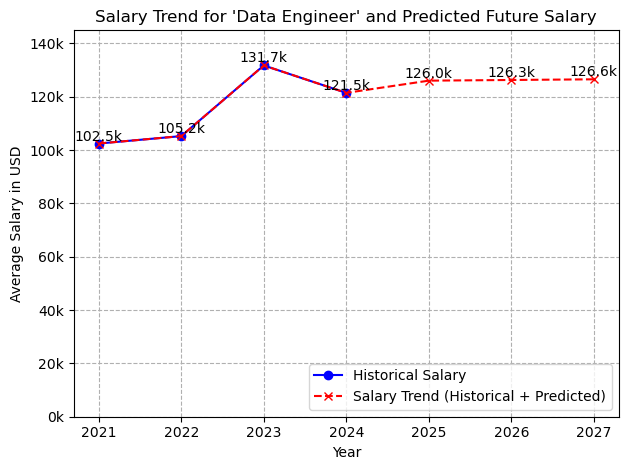

In [127]:
plt.plot(mean_salary_by_year.index, mean_salary_by_year.values, label='Historical Salary', marker='o', color='b')
    
 # Combine the historical and predicted years for smooth plotting
all_years = np.concatenate([mean_salary_by_year.index, X_future_years.flatten()])
all_salaries = np.concatenate([mean_salary_by_year.values, future_predictions])
    
# Plot the combined data (historical + predicted)
plt.plot(all_years, all_salaries, label='Salary Trend (Historical + Predicted)', marker='x', color='r', linestyle='--')
       
for i, (year, salary) in enumerate(zip(all_years, all_salaries)):
    plt.text(year, salary, f'{salary/1000:.1f}k', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary in USD')
plt.ylim(0, max(all_salaries) * 1.1)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.title(f"Salary Trend for '{input_job_title_decoded}' and Predicted Future Salary")

# Show legend
plt.legend(loc = 'lower right')
plt.grid(True, linestyle = '--')
plt.tight_layout()
plt.show()